<a href="https://colab.research.google.com/github/Muhammad-Lutfi-2002/Data_analytics/blob/main/Unilever_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# Load data
data = pd.read_csv('unilever.csv')

# Tampilkan informasi dataset
print("Dataset Info:")
print(data.info())
print("\nSample Data:")
print(data.head())

# Preprocessing
# Hapus missing values jika ada
data = data.dropna(subset=['full_text'])
data = data.reset_index(drop=True)

print("\nDataset setelah preprocessing:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conversation_id_str      307 non-null    int64 
 1   created_at               307 non-null    object
 2   favorite_count           307 non-null    int64 
 3   full_text                307 non-null    object
 4   id_str                   307 non-null    int64 
 5   image_url                60 non-null     object
 6   in_reply_to_screen_name  205 non-null    object
 7   lang                     307 non-null    object
 8   location                 165 non-null    object
 9   quote_count              307 non-null    int64 
 10  reply_count              307 non-null    int64 
 11  retweet_count            307 non-null    int64 
 12  tweet_url                307 non-null    object
 13  user_id_str              307 non-null    int64 
 14  username                 307


Distribusi Sentimen:
sentiment
Neutral     82.736156
Positive    14.332248
Negative     2.931596
Name: proportion, dtype: float64


<ipython-input-8-e9285065f4a0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='sentiment', palette='viridis')


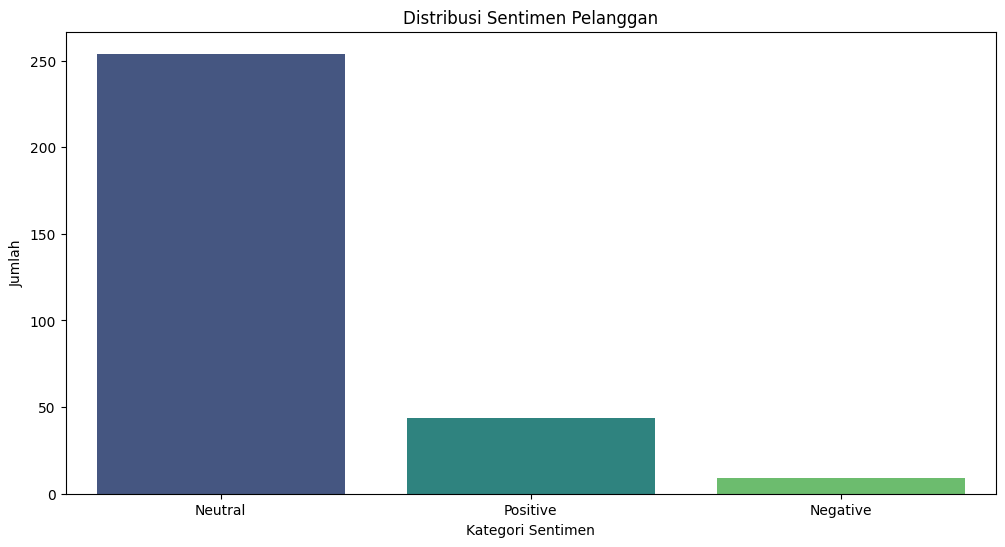

In [8]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
data['sentiment_scores'] = data['full_text'].apply(lambda x: sia.polarity_scores(str(x)))
data['compound_score'] = data['sentiment_scores'].apply(lambda x: x['compound'])

# Categorize sentiment
data['sentiment'] = data['compound_score'].apply(
    lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral')
)

# Display sentiment distribution
print("\nDistribusi Sentimen:")
print(data['sentiment'].value_counts(normalize=True) * 100)

# Visualize sentiment distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='sentiment', palette='viridis')
plt.title('Distribusi Sentimen Pelanggan')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah')
plt.show()

<ipython-input-9-3f60fc13ac7f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='cluster', y='compound_score', palette='viridis')


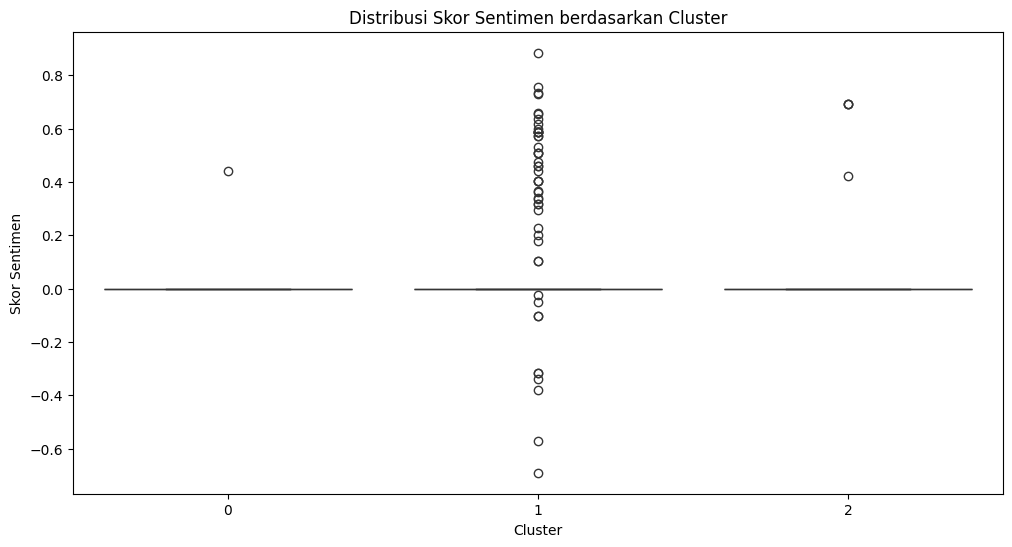

In [9]:
# Perform TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(data['full_text'].astype(str))

# Combine TF-IDF features with sentiment scores
features = np.hstack([
    tfidf_matrix.toarray(),
    data[['compound_score']].values
])

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='cluster', y='compound_score', palette='viridis')
plt.title('Distribusi Skor Sentimen berdasarkan Cluster')
plt.xlabel('Cluster')
plt.ylabel('Skor Sentimen')
plt.show()

<ipython-input-10-7053f34ce00b>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['created_at'] = pd.to_datetime(data['created_at'])


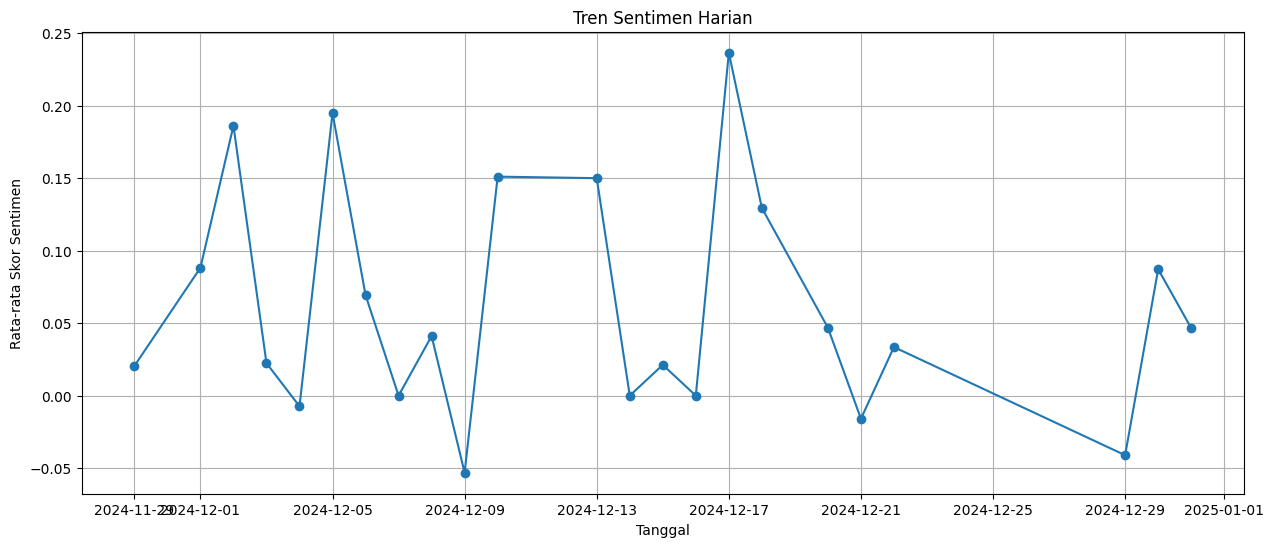

In [10]:
# Convert created_at to datetime if exists
if 'created_at' in data.columns:
    data['created_at'] = pd.to_datetime(data['created_at'])

    # Daily sentiment analysis
    daily_sentiment = data.groupby(data['created_at'].dt.date)['compound_score'].mean()

    plt.figure(figsize=(15, 6))
    daily_sentiment.plot(kind='line', marker='o')
    plt.title('Tren Sentimen Harian')
    plt.xlabel('Tanggal')
    plt.ylabel('Rata-rata Skor Sentimen')
    plt.grid(True)
    plt.show()


Analisis Cluster:

Cluster 1:
Jumlah data: 250
Rata-rata sentimen: 0.063
Distribusi sentimen:
   Neutral: 80.8%
   Positive: 15.6%
   Negative: 3.6%

Cluster 2:
Jumlah data: 49
Rata-rata sentimen: 0.051
Distribusi sentimen:
   Neutral: 91.8%
   Positive: 8.2%

Cluster 0:
Jumlah data: 8
Rata-rata sentimen: 0.055
Distribusi sentimen:
   Neutral: 87.5%
   Positive: 12.5%


<Figure size 1200x600 with 0 Axes>

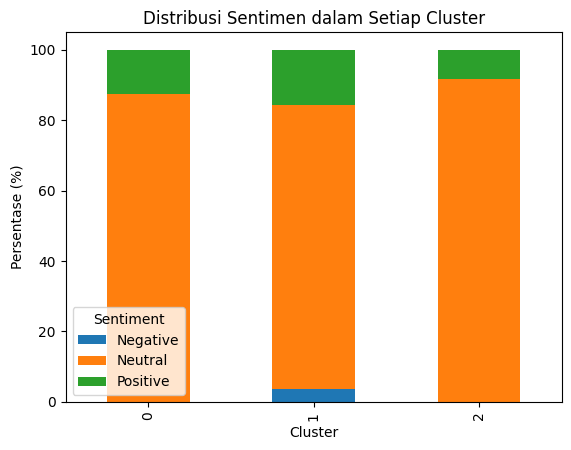

In [11]:
# Analyze clusters
cluster_insights = {}
for cluster in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster]
    cluster_insights[cluster] = {
        'size': len(cluster_data),
        'avg_sentiment': cluster_data['compound_score'].mean(),
        'sentiment_distribution': cluster_data['sentiment'].value_counts(normalize=True) * 100
    }

# Print insights
print("\nAnalisis Cluster:")
for cluster, info in cluster_insights.items():
    print(f"\nCluster {cluster}:")
    print(f"Jumlah data: {info['size']}")
    print(f"Rata-rata sentimen: {info['avg_sentiment']:.3f}")
    print("Distribusi sentimen:")
    for sentiment, pct in info['sentiment_distribution'].items():
        print(f"   {sentiment}: {pct:.1f}%")

# Visualize cluster sentiment distribution
plt.figure(figsize=(12, 6))
cluster_sentiment = pd.crosstab(data['cluster'], data['sentiment'], normalize='index') * 100
cluster_sentiment.plot(kind='bar', stacked=True)
plt.title('Distribusi Sentimen dalam Setiap Cluster')
plt.xlabel('Cluster')
plt.ylabel('Persentase (%)')
plt.legend(title='Sentiment')
plt.show()

In [13]:
# Export processed data
data.to_csv('unilever_analyzed.csv', index=False)

# Export daily sentiment if time series analysis was performed
if 'created_at' in data.columns:
    daily_sentiment.to_csv('daily_sentiment.csv')